# D. Modeling

# Load Packages

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score, precision_recall_curve, plot_precision_recall_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score
from sklearn.neighbors import KNeighborsClassifier
import datetime
import numpy as np
import pickle
import xgboost as xgb
from numpy import argmax
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold

# Load Data

In [2]:
# Specifiy filepath
filepath = '../data/interim/'

In [3]:
# Load feature and target data
X = pickle.load(open(filepath + 'X.pkl', 'rb'))
X_scaled = pickle.load(open(filepath + 'X_scaled.pkl', 'rb'))
y = pickle.load(open(filepath + 'y.pkl', 'rb'))
feature_names = pickle.load(open(filepath + 'feature_names_base.pkl', 'rb'))
X_train = pickle.load(open(filepath + 'X_train_base.pkl', 'rb'))
y_train = pickle.load(open(filepath + 'y_train_base.pkl', 'rb'))
X_test = pickle.load(open(filepath + 'X_test_base.pkl', 'rb'))
y_test = pickle.load(open(filepath + 'y_test_base.pkl', 'rb'))
application_set = pickle.load(open(filepath + 'application_df.pkl', 'rb'))

# Baseline Peformance From Logistic Regression Model

We computed various performance metrics for our baseline logistic regression model in the pre-processing notebook. The key metric for our classification task was determined to be the area under the precision-recall curve (also known as average precision) because our focus is on optimizing the proper classification of our minority class (e.g. those who said 'yes' to the marketing request). The ratio between our minority (1) and majority class (0) was determined to be 1:7.88 or approximately 0.12. This corresponds to the area under the precision-recall curve for perfect recall. It is the odds of randomly chosing an example from the minority class in the dataset. Any model we choose must beat this benchmark of 0.12 (or its representative value given the distribution of minority and majority classes in the dataset). Our logistic regression model yielded an average precision of 0.46. We will review a random forest and XGBoost algorithm to determine if we can improve on this score. We will also trial techniques such as applying class weights and resampling the data to determine if our score improves.

# Peformance Assessment Function

The function below will be used to compute a variety of performance metrics on a 10-fold cross validation set (done on the test set) and the test set. Of paramountcy are the computed values for average precision. Other revealing metrics include the precision, recall and F1 scores for a probability threshold of 50%. 

In [4]:
# Mean Average Precision on cross-validation set
def cv_performance(clf, feature = X_train, target = y_train, kfolds = 10):
    '''This function computes the average precision score for a 10-fold cross validation set, average precision on the test set
    and a precision-recall plot for the test set'''
    #Cross validation scores on training set
    #print(f'\033[4mResults for {clf.__name__} \033[0m')
    cv_results = cross_validate(estimator = clf, X = feature, y = target, scoring = 'average_precision', cv= kfolds)
    cv_scores = cv_results['test_score']
    return cv_scores

def pred(clf, Xtr = X_train, ytr = y_train, Xte = X_test, pipeline = False, **kwargs):
    clf.fit(Xtr, ytr)
    y_pred = clf.predict(Xte)
    y_prob = clf.predict_proba(Xte)[:, 1]
    if pipeline:
        for key, value in kwargs.items():
            if key == 'model':
                coef = clf.named_steps[value].coef_[0]
            if key == 'select':
                mask = clf.named_steps[value].get_support()
    else:
        coef = clf.coef_[0]
        mask = None
    return y_pred, y_prob, coef, mask

def pred_tree(clf, Xtr = X_train, ytr = y_train, Xte = X_test, pipeline = False, **kwargs):
    clf.fit(Xtr, ytr)
    y_pred = clf.predict(Xte)
    y_prob = clf.predict_proba(Xte)[:, 1]
    if pipeline:
        for key, value in kwargs.items():
            if key == 'model':
                coef = clf.named_steps[value].feature_importances_
            if key == 'select':
                mask = clf.named_steps[value].get_support()
    else:
        coef = clf.feature_importances_
        mask = None
    return y_pred, y_prob, coef, mask    
    
def auc_plot(y_test, y_prob, label):
    precision, recall, thresholds = precision_recall_curve(y_test, y_prob) 
    plt.plot(recall, precision, label = label, marker = '.')
    
def cv_mean_std(cv_scores):
    cv_mean = cv_scores.mean()
    cv_std = cv_scores.std()
    return cv_mean, cv_std

def limits(mean, std):
    upper = mean + std
    lower = mean -std
    return lower, upper   

# Baseline Performance of Algorithms

## Logistic Regression

We already determined the baseline performance for the logistic regression algorithm. However, we will review the associated precision-recall curve. 

In [5]:
logreg = LogisticRegression(random_state = 77, max_iter = 1000)

In [6]:
logreg_cv = cv_performance(logreg)

In [7]:
logreg_cv_mean, logreg_cv_std = cv_mean_std(logreg_cv)

In [8]:
logreg_cv_mean, logreg_cv_std

(0.4533335978961531, 0.03112362395308293)

In [9]:
logreg_pred, logreg_prob, logreg_coef, _ = pred(logreg)

In [10]:
logreg_auc_pr = average_precision_score(y_test, logreg_prob)
logreg_auc_pr

0.47551327455602055

In [11]:
logreg_features = pd.DataFrame(logreg_coef, index = feature_names, columns = ['coefficient'])
logreg_features.reindex(logreg_features.coefficient.abs().sort_values(ascending = False).index).head(10)

,coefficient
cpi,1.054576
euribor3m,-0.903468
noEmployed,0.855754
euribor3m_grp_3.301_4.2,-0.717255
employmentRate_grp_0.1_1.5,-0.467143
employmentRate_grp_neg0.9_0,0.456644
month_nov,0.333957
currentCampaignContacts,-0.326053
euribor3m_grp_rr,0.239489
cci,0.235932


The cross validation AUC-PR score of 0.45 is close to the test set score of 0.46. There is therefore minimal overfitting in the model. This test performance is also better than the no-skill performance of 0.11, however the recall on the minority class of 0.25 is low. 

## Logistic regression with feature selection

In [12]:
#Instantiate transformer that selects features with coefficients greater than the mean coefficient
selector = SelectFromModel(logreg, prefit = False)

In [13]:
#Instantiate pipeline that select important features and trains a logistic regression model
select_logreg = Pipeline(steps = [('selector',selector), ('logreg', logreg)])

In [14]:
#Obtain the 5 fold cross validation performance of model with pre-selected features
select_logreg_cv = cv_performance(select_logreg, kfolds = 5)

In [15]:
#Review mean and standard deviation of logistic regression model with pre-selected features
select_logreg_cv_mean, select_logreg_cv_std = cv_mean_std(select_logreg_cv)
select_logreg_cv_mean, select_logreg_cv_std

(0.4105143078680767, 0.027657325881146985)

In [16]:
#Obtain predictions, probabilities and coeffificents of logistic regression model with pre-selected features
select_logreg_pred, select_logreg_prob, select_logreg_coef, select_logreg_mask = pred(clf = select_logreg, \
            Xtr = X_train, ytr = y_train, Xte = X_test, pipeline = True, model = 'logreg', select = 'selector')

In [17]:
select_logreg_auc_pr = average_precision_score(y_test, select_logreg_prob)
select_logreg_auc_pr

0.465876242463211

In [18]:
logreg_select_features = pd.DataFrame(select_logreg_coef, index = feature_names[select_logreg_mask], columns = ['coefficient'])
logreg_select_features.reindex(logreg_select_features.coefficient.abs().sort_values(ascending = False).index).head(10)

,coefficient
euribor3m,-1.064822
cpi,0.967789
employmentRate_grp_neg0.9_0,0.845725
euribor3m_grp_3.301_4.2,-0.801990
euribor3m_grp_rr,0.732143
noEmployed,0.678280
employmentRate_grp_0.1_1.5,-0.519269
cci,0.325329
cpi_grp_93.001_94,0.266817
daysLastContacted,-0.251106


## Logistic regression with class weights

In [19]:
logreg_cw = LogisticRegression(class_weight = {0: 1, 1: 8}, max_iter = 10000, random_state = 77)

In [20]:
logreg_cw_cv = cv_performance(logreg_cw)

In [21]:
logreg_cw_cv_mean, logreg_cw_cv_std = cv_mean_std(logreg_cw_cv)
logreg_cw_cv_mean, logreg_cw_cv_std

(0.449333817479881, 0.03235619719570669)

In [22]:
logreg_cw_pred, logreg_cw_prob, logreg_cw_coef, logreg_cw_mask = pred(logreg_cw)

In [23]:
logreg_cw_features = pd.DataFrame(logreg_cw_coef, index = feature_names, columns = ['coefficient'])
logreg_cw_features.reindex(logreg_cw_features.coefficient.abs().sort_values(ascending = False).index).head(10)

,coefficient
euribor3m,-2.161277
cpi,1.468551
noEmployed,1.268859
cci,0.738183
euribor3m_grp_3.301_4.2,-0.736949
employmentRate_grp_neg0.9_0,0.560133
employmentRate_grp_0.1_1.5,-0.428410
month_nov,0.427498
currentCampaignContacts,-0.389711
cci_grp_neg51_neg46,0.388036


In [24]:
logreg_cw_auc_pr = average_precision_score(y_test, logreg_cw_prob)
logreg_cw_auc_pr

0.46980538358872587

## Logistic regression with hyperparamter tuning

In [25]:
#Define parameters
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c = [100, 10, 1.0, 0.1, 0.01]
#Define grid search
param_grid = dict(solver = solvers, penalty = penalty, C = c)
logreg_search = GridSearchCV(estimator = logreg, param_grid = param_grid, n_jobs=-1, cv = 5, scoring='average_precision',error_score=0)
logreg_search.fit(X_train, y_train);

In [26]:
logreg_search.best_score_, logreg_search.cv_results_['std_test_score'][logreg_search.best_index_]

(0.45112559553015297, 0.022857191440560393)

In [27]:
logreg_search.best_params_

{'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [28]:
logreg_hyp = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg', max_iter = 10000, random_state = 77)

In [29]:
logreg_hyp_pred, logreg_hyp_prob, logreg_hyp_coef, logreg_hyp_mask = pred(logreg_hyp)

In [30]:
logreg_hyp_features = pd.DataFrame(logreg_hyp_coef, index = feature_names, columns = ['coefficient'])
logreg_hyp_features.reindex(logreg_hyp_features.coefficient.abs().sort_values(ascending = False).index).head(10)

,coefficient
cpi,1.065987
euribor3m,-0.889792
noEmployed,0.868012
euribor3m_grp_3.301_4.2,-0.717333
employmentRate_grp_0.1_1.5,-0.472305
employmentRate_grp_neg0.9_0,0.459591
month_nov,0.333881
currentCampaignContacts,-0.330368
cci,0.253859
euribor3m_grp_rr,0.243000


In [31]:
logreg_hyp_auc_pr = average_precision_score(y_test, logreg_hyp_prob)
logreg_hyp_auc_pr

0.4754929359535215

In [32]:
logreg_aucpr_cv_scores = [logreg_cv_mean, select_logreg_cv_mean, logreg_cw_cv_mean, logreg_search.best_score_]
logreg_aucpr_test_scores = [logreg_auc_pr, select_logreg_auc_pr, logreg_cw_auc_pr, logreg_hyp_auc_pr]
logreg_performance_scores = dict(logreg_cv_scores =  logreg_aucpr_cv_scores, logreg_test_scores = logreg_aucpr_test_scores)
logreg_names = ['Logreg', 'Logreg w/ feature selection', 'Logreg w/ class weights', 'Logreg w/ tuning hyperparamters']
logreg_probs = [logreg_prob, select_logreg_prob, logreg_cw_prob, logreg_hyp_prob]
logreg_info = zip(logreg_names, logreg_probs)

In [33]:
logreg_perf_df = pd.DataFrame(logreg_performance_scores, index = logreg_names)
logreg_perf_df.sort_values(by = 'logreg_cv_scores', ascending = False)

,logreg_cv_scores,logreg_test_scores
Logreg,0.453334,0.475513
Logreg w/ tuning hyperparamters,0.451126,0.475493
Logreg w/ class weights,0.449334,0.469805
Logreg w/ feature selection,0.410514,0.465876


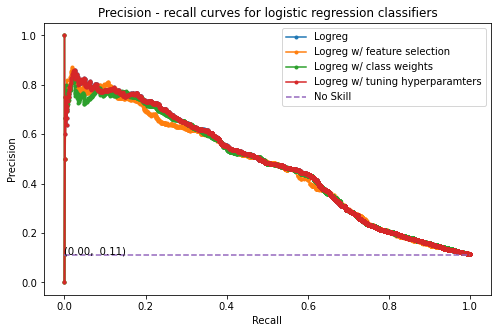

In [34]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (8, 5))

for name, prob in logreg_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for logistic regression classifiers')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend()
plt.savefig('..\\reports\\figures\\logreg.png', bbox_inches="tight");

Basic logistic regression classifier seems to work the best.

## Random Forest

Let us assess the performance of the baseline random forest model. 

In [35]:
rf = RandomForestClassifier(random_state = 77)

In [36]:
rf_cv = cv_performance(rf)

The closeness of the cross validation score for the training set and the score for the test set suggest that there is minimal overfitting. The cross performance of 0.4 is worse than that observed from the logistic regression algorithm (0.44), suggesting that the logistic regression model performs better than random forest. However, the random forest offers better test scores on precision than the logistic regression model.  

In [37]:
rf_cv_mean, rf_cv_std = cv_mean_std(rf_cv)
rf_cv_mean, rf_cv_std

(0.40397960734393423, 0.027580319458172943)

In [38]:
rf_pred, rf_prob, rf_coef, _ = pred_tree(rf)

In [39]:
rf_auc_pr = average_precision_score(y_test, rf_prob)
rf_auc_pr

0.4140080767074705

In [40]:
rf_features = pd.DataFrame(rf_coef, index = feature_names, columns = ['impurity'])
rf_features.reindex(rf_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
age,0.089726
euribor3m,0.078598
job_rr,0.033099
education_rr,0.028873
dayOfWeek_rr,0.028094
noEmployed,0.025499
currentCampaignContacts,0.024551
currentCampaignContacts_grp_rr,0.024017
age_grp_rr,0.021735
daysLastContacted,0.021475


## Random forest with feature selection

In [41]:
#Instantiate transformer that selects features with impurities greater than the mean impurity
selector_rf = SelectFromModel(rf, prefit = False)

In [42]:
#Instantiate pipeline that select important features and trains a logistic regression model
select_rf = Pipeline(steps = [('selector_rf',selector_rf), ('rf', rf)])

In [43]:
#Obtain the 5 fold cross validation performance of model with pre-selected features
select_rf_cv = cv_performance(select_rf, kfolds = 5)

In [44]:
#Review mean and standard deviation of logistic regression model with pre-selected features
select_rf_cv_mean, select_rf_cv_std = cv_mean_std(select_rf_cv)
select_rf_cv_mean, select_rf_cv_std

(0.3852413556566428, 0.019886128266401133)

In [45]:
#Obtain predictions, probabilities and coeffificents of logistic regression model with pre-selected features
select_rf_pred, select_rf_prob, select_rf_coef, select_rf_mask = pred_tree(clf = select_rf, \
            Xtr = X_train, ytr = y_train, Xte = X_test, pipeline = True, model = 'rf', select = 'selector_rf')

In [46]:
select_rf_auc_pr = average_precision_score(y_test, select_rf_prob)
select_rf_auc_pr

0.4022934164237752

In [47]:
rf_select_features = pd.DataFrame(select_rf_coef, index = feature_names[select_rf_mask], columns = ['impurity'])
rf_select_features.reindex(rf_select_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
age,0.117203
euribor3m,0.106621
job_rr,0.052060
education_rr,0.043941
noEmployed,0.036253
currentCampaignContacts_grp_rr,0.030058
currentCampaignContacts,0.030032
dayOfWeek_rr,0.029522
age_grp_rr,0.027648
noEmployed_grp_rr,0.024342


## Random forest with class weights

In [48]:
rf_cw = RandomForestClassifier(class_weight = {0: 1, 1: 8}, random_state = 77)

In [49]:
rf_cw_cv = cv_performance(rf_cw)

In [50]:
rf_cw_cv_mean, rf_cw_cv_std = cv_mean_std(rf_cw_cv)
rf_cw_cv_mean, rf_cw_cv_std

(0.402201457265685, 0.030524679034745452)

In [51]:
rf_cw_pred, rf_cw_prob, rf_cw_coef, _ = pred_tree(rf_cw)

In [52]:
rf_cw_features = pd.DataFrame(rf_cw_coef, index = feature_names, columns = ['impurity'])
rf_cw_features.reindex(rf_cw_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
age,0.075998
euribor3m,0.075917
noEmployed,0.035492
job_rr,0.032824
education_rr,0.027876
dayOfWeek_rr,0.026953
euribor3m_grp_rr,0.026203
currentCampaignContacts,0.025824
currentCampaignContacts_grp_rr,0.024373
employmentRate_grp_rr,0.022253


In [53]:
rf_cw_auc_pr = average_precision_score(y_test, rf_cw_prob)
rf_cw_auc_pr

0.4135837406458667

## Random forest with hyperparameter tuning

In [54]:
#Define parameters
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
#Define grid search
param_grid = dict(n_estimators = n_estimators, max_features = max_features)
rf_search = GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs=-1, cv = 5, scoring='average_precision',error_score=0)
rf_search.fit(X_train, y_train);

In [55]:
rf_search.best_score_, rf_search.cv_results_['std_test_score'][rf_search.best_index_]

(0.4131665951667679, 0.022924845223318085)

In [56]:
rf_search.best_params_

{'max_features': 'sqrt', 'n_estimators': 1000}

In [57]:
rf_hyp = RandomForestClassifier(max_features = 'sqrt', n_estimators = 1000, random_state = 77)

In [58]:
rf_hyp_pred, rf_hyp_prob, rf_hyp_coef, rf_hyp_mask = pred_tree(rf_hyp)

In [59]:
rf_hyp_features = pd.DataFrame(rf_hyp_coef, index = feature_names, columns = ['impurity'])
rf_hyp_features.reindex(rf_hyp_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
age,0.088991
euribor3m,0.076998
job_rr,0.033344
education_rr,0.028560
dayOfWeek_rr,0.028159
currentCampaignContacts,0.024709
noEmployed,0.024601
currentCampaignContacts_grp_rr,0.024204
age_grp_rr,0.021966
marital_rr,0.015604


In [60]:
rf_hyp_auc_pr = average_precision_score(y_test, rf_hyp_prob)
rf_hyp_auc_pr

0.4206094842852117

In [61]:
rf_aucpr_cv_scores = [rf_cv_mean, select_rf_cv_mean, rf_cw_cv_mean, rf_search.best_score_]
rf_aucpr_test_scores = [rf_auc_pr, rf_auc_pr, rf_cw_auc_pr, rf_hyp_auc_pr]
rf_performance_scores = dict(rf_cv_scores =  rf_aucpr_cv_scores, rf_test_scores = rf_aucpr_test_scores)
rf_names = ['rf', 'rf w/ feature selection', 'rf w/ class weights', 'rf w/ tuning hyperparamters']
rf_probs = [rf_prob, select_rf_prob, rf_cw_prob, rf_hyp_prob]
rf_info = zip(rf_names, rf_probs)

In [62]:
rf_perf_df = pd.DataFrame(rf_performance_scores, index = rf_names)
rf_perf_df.sort_values(by = 'rf_cv_scores', ascending = False)

,rf_cv_scores,rf_test_scores
rf w/ tuning hyperparamters,0.413167,0.420609
rf,0.403980,0.414008
rf w/ class weights,0.402201,0.413584
rf w/ feature selection,0.385241,0.414008


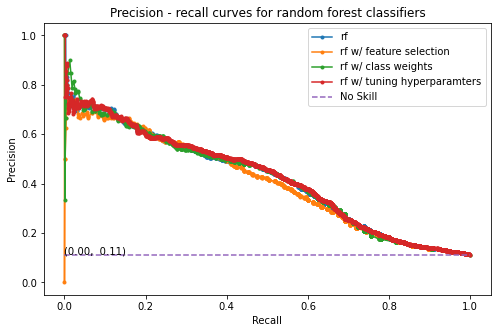

In [63]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (8, 5))

for name, prob in rf_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for random forest classifiers')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend()
plt.savefig('..\\reports\\figures\\rf.png', bbox_inches="tight");

## XGBoost Classifier

In [64]:
xg = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', seed= 77)

In [65]:
xg_cv = cv_performance(xg)

The performance of the XGBoost model is better than the random forest model but worse than the logistic regression model.

In [66]:
xg_cv_mean, xg_cv_std = cv_mean_std(xg_cv)
xg_cv_mean, xg_cv_std

(0.43268380524360117, 0.024451964443255994)

In [67]:
xg_pred, xg_prob, xg_coef, _ = pred_tree(xg)

In [68]:
xg_auc_pr = average_precision_score(y_test, xg_prob)
xg_auc_pr

0.45733648264504656

In [69]:
xg_features = pd.DataFrame(xg_coef, index = feature_names, columns = ['impurity'])
xg_features.reindex(xg_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
noEmployed,0.390820
lastCampaignOutcome_rr,0.064431
month_rr,0.026674
daysLastContacted,0.022545
month_oct,0.014783
employmentRate_grp_rr,0.012202
daysLastContacted_grp_7days,0.011233
contactType_rr,0.010701
month_dec,0.010372
euribor3m,0.010309


## XGBoost with feature selection

In [70]:
#Instantiate transformer that selects features with impurities greater than the mean impurity
selector_xg = SelectFromModel(xg, prefit = False)

In [71]:
#Instantiate pipeline that select important features and trains a XGBoost model
select_xg = Pipeline(steps = [('selector_xg',selector_xg), ('xg', xg)])

In [72]:
#Obtain the 5 fold cross validation performance of model with pre-selected features
select_xg_cv = cv_performance(select_xg, kfolds = 5)

In [73]:
#Review mean and standard deviation of logistic regression model with pre-selected features
select_xg_cv_mean, select_xg_cv_std = cv_mean_std(select_xg_cv)
select_xg_cv_mean, select_xg_cv_std

(0.44057151223634267, 0.019304425262752452)

In [74]:
#Obtain predictions, probabilities and coeffificents of logistic regression model with pre-selected features
select_xg_pred, select_xg_prob, select_xg_coef, select_xg_mask = pred_tree(clf = select_xg, \
            Xtr = X_train, ytr = y_train, Xte = X_test, pipeline = True, model = 'xg', select = 'selector_xg')

In [75]:
select_xg_auc_pr = average_precision_score(y_test, select_xg_prob)
select_xg_auc_pr

0.45876740787701087

In [76]:
xg_select_features = pd.DataFrame(select_xg_coef, index = feature_names[select_xg_mask], columns = ['impurity'])
xg_select_features.reindex(xg_select_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
noEmployed,0.648102
month_rr,0.067980
daysLastContacted,0.031059
month_oct,0.030846
month_apr,0.029191
employmentRate_grp_rr,0.028116
lastCampaignOutcome_failure,0.019034
euribor3m,0.016720
contactType_rr,0.015942
lastCampaignOutcome_rr,0.015712


## XGBoost with class weights

In [77]:
xg_cw = xgb.XGBClassifier(objective = 'binary:logistic', use_label_encoder = False, eval_metric = 'logloss', scale_pos_weight = 8, seed = 77)

In [78]:
xg_cw_cv = cv_performance(xg_cw)

In [79]:
xg_cw_cv_mean, xg_cw_cv_std = cv_mean_std(xg_cw_cv)
xg_cw_cv_mean, xg_cw_cv_std

(0.41764596625545075, 0.02122821630435805)

In [80]:
xg_cw_pred, xg_cw_prob, xg_cw_coef, _ = pred_tree(xg_cw)

In [81]:
xg_cw_auc_pr = average_precision_score(y_test, xg_cw_prob)
xg_cw_auc_pr

0.4493580813408267

In [82]:
xg_cw_features = pd.DataFrame(xg_cw_coef, index = feature_names, columns = ['impurity'])
xg_cw_features.reindex(xg_cw_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
noEmployed,0.434847
month_rr,0.046319
cci,0.016354
lastCampaignOutcome_rr,0.014824
daysLastContacted,0.011964
contactType_rr,0.010929
employmentRate_grp_neg2.4_neg1.5,0.010908
lastCampaignOutcome_failure,0.010143
noEmployed_grp_5050.1_5140,0.009639
job_management,0.009581


## XGBoost with hyperparameter tuning

In [83]:
#Define parameters
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]
#Define grid search
param_grid = dict(subsample = subsample, max_depth = max_depth)
xg_search = GridSearchCV(estimator = xg, param_grid = param_grid, cv = 5, scoring='average_precision',error_score=0)
xg_search.fit(X_train, y_train);

In [84]:
xg_search.best_score_, xg_search.cv_results_['std_test_score'][xg_search.best_index_]

(0.46068397003152456, 0.016459925994177872)

In [85]:
xg_search.best_params_

{'max_depth': 3, 'subsample': 1.0}

In [86]:
xg_hyp = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', subsample = 1, max_depth = 3, seed= 77)

In [87]:
xg_hyp_pred, xg_hyp_prob, xg_hyp_coef, xg_hyp_mask = pred_tree(xg_hyp)

In [88]:
xg_hyp_features = pd.DataFrame(xg_hyp_coef, index = feature_names, columns = ['impurity'])
xg_hyp_features.reindex(xg_hyp_features.impurity.abs().sort_values(ascending = False).index).head(10)

,impurity
noEmployed,0.399593
lastCampaignOutcome_rr,0.086378
month_rr,0.064311
daysLastContacted,0.028735
employmentRate,0.022260
lastCampaignOutcome_failure,0.018553
month_oct,0.017735
dayOfWeek_tue,0.016052
euribor3m,0.014887
employmentRate_grp_neg0.9_0,0.012689


In [89]:
xg_hyp_auc_pr = average_precision_score(y_test, xg_hyp_prob)
xg_hyp_auc_pr

0.4814558916397618

In [90]:
xg_aucpr_cv_scores = [xg_cv_mean, select_xg_cv_mean, xg_cw_cv_mean, xg_search.best_score_]
xg_aucpr_test_scores = [xg_auc_pr, xg_auc_pr, xg_cw_auc_pr, xg_hyp_auc_pr]
xg_performance_scores = dict(xg_cv_scores =  xg_aucpr_cv_scores, xg_test_scores = xg_aucpr_test_scores)
xg_names = ['xg', 'xg w/ feature selection', 'xg w/ class weights', 'xg w/ tuning hyperparamters']
xg_probs = [xg_prob, select_xg_prob, xg_cw_prob, xg_hyp_prob]
xg_info = zip(xg_names, xg_probs)

In [91]:
xg_perf_df = pd.DataFrame(xg_performance_scores, index = xg_names)
xg_perf_df.sort_values(by = 'xg_cv_scores', ascending = False)

,xg_cv_scores,xg_test_scores
xg w/ tuning hyperparamters,0.460684,0.481456
xg w/ feature selection,0.440572,0.457336
xg,0.432684,0.457336
xg w/ class weights,0.417646,0.449358


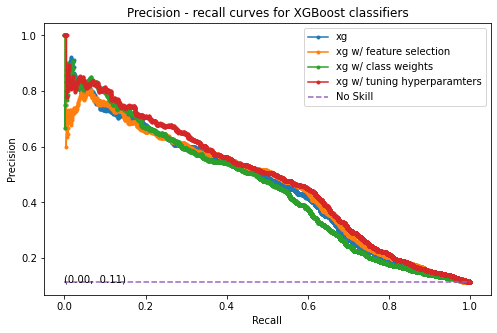

In [92]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (8, 5))

for name, prob in xg_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for XGBoost classifiers')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend()
plt.savefig('..\\reports\\figures\\xg.png', bbox_inches="tight");

## Comparing the best models from each algorithm

In [93]:
best_aucpr_cv_scores = [logreg_cv_mean, rf_search.best_score_, xg_search.best_score_]
best_aucpr_test_scores = [logreg_auc_pr, rf_hyp_auc_pr, xg_hyp_auc_pr]
best_performance_scores = dict(cv_scores =  best_aucpr_cv_scores, test_scores = best_aucpr_test_scores)
best_models = ['logreg', 'rf w/ hyperparameter tuning', 'xg w/ hyperparameter tuning']
best_probs = [logreg_prob, rf_hyp_prob, xg_hyp_prob]
models_info = zip(best_models, best_probs)

In [94]:
best_perf_df = pd.DataFrame(best_performance_scores, index = best_models)
best_perf_df.sort_values(by = 'cv_scores', ascending = False)

,cv_scores,test_scores
xg w/ hyperparameter tuning,0.460684,0.481456
logreg,0.453334,0.475513
rf w/ hyperparameter tuning,0.413167,0.420609


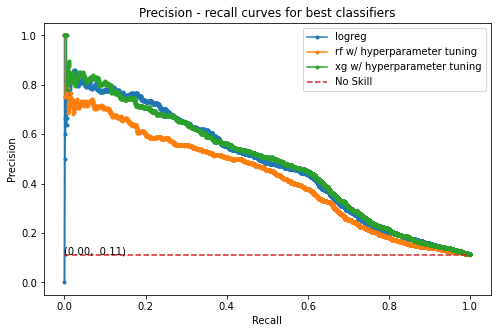

In [95]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (8, 5))

for name, prob in models_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for best classifiers')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend()
plt.savefig('..\\reports\\figures\\best.png', bbox_inches="tight");

It seems the XGBoost with tuned parameters offer the best results.

# Undersampling and Oversampling

Another technique to deal with the imbalanced nature of our data is to resample the data in such a way that creates an equal number of observations for our target features - in this case, having the same number of clients that said 'yes' and 'no' to the marketing camapagne. The imbalanced nature of our dataset may result in models that are biased towards the majority class due to their comparatively higher numbers. Balancing the dataset may reduce this bias. We accomplish this by either reducing the number of clients in the majority class to equal that of the minority class or increasing the number of clients in the minority class to equal that of the majority class by resampling with replacement. We will try both approaches. We will balance only data in our training set. The test set (as usual) will be used to determine the performance of our balancing techniques.

## Random Undersampling (RU)

In this case, we will randomly select a number of clients in the majority class to equal that of the minority class. 

In [96]:
#Create scaled dataframe to undersample from 
df = pd.merge(pd.DataFrame(X_train, columns = feature_names), y_train, left_index = True, right_index = True)
df.head(2)

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,age_grp_rr,...,cci_grp_neg51_neg46,euribor3m_grp_0.6_1.5,euribor3m_grp_1.501_2.4,euribor3m_grp_2.401_3.3,euribor3m_grp_3.301_4.2,euribor3m_grp_4.201_5.1,noEmployed_grp_4960_5050,noEmployed_grp_5050.1_5140,noEmployed_grp_5140.1_5230,response
0,0.957287,0.156082,0.195329,-0.349869,-0.115984,-0.649037,-0.323487,0.230256,0.397942,-0.526988,...,-0.523788,-0.687229,-0.08305,-0.00697,3.248739,-1.189168,-0.29496,-0.573648,0.698057,0
1,-1.441852,0.156082,0.195329,-0.349869,0.838905,0.591467,-0.474739,0.771698,0.845115,0.591103,...,-0.523788,-0.687229,-0.08305,-0.00697,-0.307812,0.840924,-0.29496,-0.573648,0.698057,0


In [97]:
#Determine number of 'yes' responses as basis to undersample
df.response.value_counts()

0    19022
1     1135
Name: response, dtype: int64

In [98]:
# Shuffle data
df_shuffled = df.sample(frac=1)

# Create subsamples for 'yes' class, which is 1134 rows.
yes_df = df_shuffled.loc[df_shuffled.response == 1]
no_df = df_shuffled.loc[df_shuffled.response == 0][:1134]

normal_df = pd.concat([yes_df, no_df])

# Shuffle dataframe rows
df_undersampled = normal_df.sample(frac=1, random_state= 77)

df_undersampled.head()

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,age_grp_rr,...,cci_grp_neg51_neg46,euribor3m_grp_0.6_1.5,euribor3m_grp_1.501_2.4,euribor3m_grp_2.401_3.3,euribor3m_grp_3.301_4.2,euribor3m_grp_4.201_5.1,noEmployed_grp_4960_5050,noEmployed_grp_5050.1_5140,noEmployed_grp_5140.1_5230,response
14340,0.669391,0.156082,0.195329,-0.349869,0.838905,-0.227473,0.951353,0.775157,0.845115,-0.526988,...,-0.523788,-0.687229,-0.08305,-0.00697,-0.307812,0.840924,-0.294960,-0.573648,0.698057,0
15925,1.149219,-0.204866,0.195329,-0.349869,-1.198192,-1.179448,-1.231000,-1.307575,-0.940808,-0.104129,...,1.909170,1.455119,-0.08305,-0.00697,-0.307812,-1.189168,-0.294960,1.743230,-1.432548,1
14574,-1.249921,-0.565814,0.195329,-0.349869,-1.198192,-0.865002,-1.425467,-1.224542,-0.940808,0.591103,...,1.909170,1.455119,-0.08305,-0.00697,-0.307812,-1.189168,-0.294960,1.743230,-1.432548,0
24032,-0.290265,-0.204866,0.195329,-0.349869,0.838905,-0.227473,0.951353,0.777464,0.845115,-0.258807,...,-0.523788,-0.687229,-0.08305,-0.00697,-0.307812,0.840924,-0.294960,-0.573648,0.698057,1
14618,-0.482196,-0.565814,-5.130277,3.700015,-2.216741,-1.977655,2.939239,-1.653544,-2.070509,-0.258807,...,-0.523788,1.455119,-0.08305,-0.00697,-0.307812,-1.189168,3.390292,-0.573648,-1.432548,1


In [99]:
#Check distribution of response
df_undersampled.response.value_counts()

1    1135
0    1134
Name: response, dtype: int64

In [100]:
#Create X_train and y_train for undersampled dataframe
X_train_undersampled = df_undersampled.drop(columns = ['response'])
y_train_undersampled = df_undersampled.response.values.ravel()

### Train Models on Undersampled Dataframe And Assess Performance

In [101]:
ru_logreg_cv = cv_performance(logreg, feature = X_train_undersampled, target = y_train_undersampled)
ru_rf_hyp_cv = cv_performance(rf_hyp, feature = X_train_undersampled, target = y_train_undersampled)
ru_xg_hyp_cv = cv_performance(xg_hyp, feature = X_train_undersampled, target = y_train_undersampled)

In [102]:
ru_logreg_cv_mean, ru_logreg_cv_std = cv_mean_std(ru_logreg_cv)
ru_rf_hyp_cv_mean, ru_rf_cv_std = cv_mean_std(ru_rf_hyp_cv)
ru_xg_hyp_cv_mean, ru_xg_hyp_cv_std = cv_mean_std(ru_xg_hyp_cv)

In [103]:
ru_logreg_pred, ru_logreg_prob, ru_logreg_coef, _ = pred(logreg, Xtr = X_train_undersampled, ytr = y_train_undersampled)
ru_rf_hyp_pred, ru_rf_hyp_prob, ru_rf_hyp_coef, _ = pred_tree(rf_hyp, Xtr = X_train_undersampled, ytr = y_train_undersampled)
ru_xg_hyp_pred, ru_xg_hyp_prob, ru_xg_hyp_coef, _ = pred_tree(xg_hyp, Xtr = X_train_undersampled, ytr = y_train_undersampled)

In [104]:
ru_logreg_auc_pr = average_precision_score(y_test, ru_logreg_prob)
ru_rf_hyp_auc_pr = average_precision_score(y_test, ru_rf_hyp_prob)
ru_xg_hyp_auc_pr = average_precision_score(y_test, ru_xg_hyp_prob)

In [105]:
ru_aucpr_cv_scores = [ru_logreg_cv_mean, ru_rf_hyp_cv_mean, ru_xg_hyp_cv_mean]
ru_aucpr_test_scores = [ru_logreg_auc_pr, ru_rf_hyp_auc_pr, ru_xg_hyp_auc_pr]
ru_performance_scores = dict(ru_cv_scores =  ru_aucpr_cv_scores, ru_test_scores = ru_aucpr_test_scores)
ru_probs = [ru_logreg_prob, ru_rf_hyp_prob, ru_xg_hyp_prob]
ru_info = zip(best_models, ru_probs)

In [106]:
ru_perf_df = pd.DataFrame(ru_performance_scores, index = best_models)
ru_perf_df.sort_values(by = 'ru_test_scores', ascending = False)

,ru_cv_scores,ru_test_scores
logreg,0.519437,0.139163
xg w/ hyperparameter tuning,0.505656,0.138683
rf w/ hyperparameter tuning,0.518432,0.111726


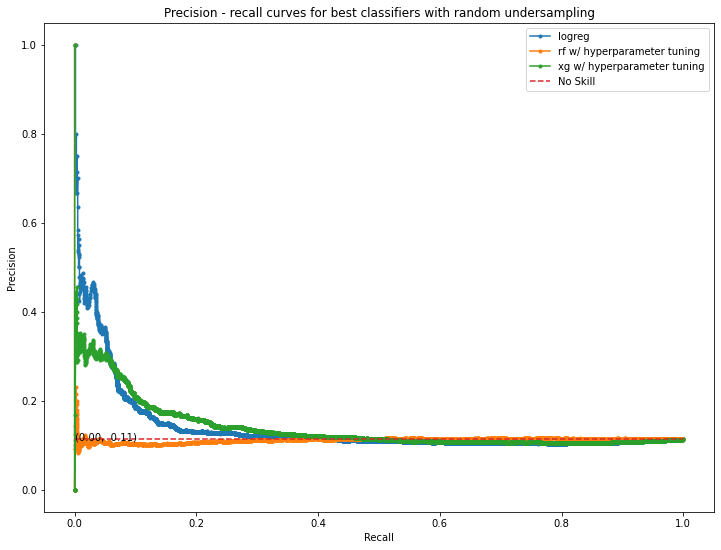

In [107]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (12, 9))

for name, prob in ru_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for best classifiers with random undersampling')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend();

The undersampled models performed well on the training set, but substantially worse on the test set. This implies that the models created by undersampled data is significantly different from those created by the more representative dataset.

## Random Oversampling (RO)

In this case, we will oversample the minority class to equal the number of clients in the majority class.

In [108]:
#Determine number of 'yes' and 'no' responses as basis to oversample
df.response.value_counts()

0    19022
1     1135
Name: response, dtype: int64

We need 19,045 samples of the 'yes' class.

In [109]:
# Shuffle data
df_shuffled_over = df.sample(frac=1)

# Create subsamples for 'yes' class, which is 1134 rows.
yes_df_over = df_shuffled_over.loc[df_shuffled_over.response == 1].sample(n = 19045, replace = True)
no_df_over = df_shuffled_over.loc[df_shuffled_over.response == 0]

normal_df_over = pd.concat([yes_df_over, no_df_over])

# Shuffle dataframe rows
df_oversampled = normal_df_over.sample(frac=1, random_state= 77)

df_oversampled.head()

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,age_grp_rr,...,cci_grp_neg51_neg46,euribor3m_grp_0.6_1.5,euribor3m_grp_1.501_2.4,euribor3m_grp_2.401_3.3,euribor3m_grp_3.301_4.2,euribor3m_grp_4.201_5.1,noEmployed_grp_4960_5050,noEmployed_grp_5050.1_5140,noEmployed_grp_5140.1_5230,response
24037,-0.674127,-0.565814,0.195329,-0.349869,-1.198192,-0.865002,-1.425467,-1.275285,-0.940808,-0.258807,...,1.909170,1.455119,-0.08305,-0.00697,-0.307812,-1.189168,-0.29496,1.743230,-1.432548,1
9841,0.477460,-0.565814,0.195329,-0.349869,0.647927,0.722774,0.886530,0.711153,0.331489,-0.526988,...,-0.523788,-0.687229,-0.08305,-0.00697,-0.307812,0.840924,-0.29496,-0.573648,0.698057,1
27973,-0.290265,-0.565814,0.195329,-0.349869,-1.198192,-1.179448,-1.231000,-1.371003,-0.940808,-0.258807,...,1.909170,1.455119,-0.08305,-0.00697,-0.307812,-1.189168,-0.29496,1.743230,-1.432548,1
2511,-1.345886,-0.565814,0.195329,1.675073,-1.198192,-1.179448,-1.231000,-1.367543,-0.940808,0.591103,...,1.909170,1.455119,-0.08305,-0.00697,-0.307812,-1.189168,-0.29496,1.743230,-1.432548,0
18116,-0.290265,-0.565814,0.195329,-0.349869,-0.115984,-0.649037,-0.323487,0.261970,0.397942,-0.258807,...,-0.523788,-0.687229,-0.08305,-0.00697,3.248739,-1.189168,-0.29496,-0.573648,0.698057,1


In [110]:
#Check distribution of response
df_oversampled.response.value_counts()

1    19045
0    19022
Name: response, dtype: int64

In [111]:
#Create X_train and y_train for undersampled dataframe
X_train_oversampled = df_oversampled.drop(columns = ['response'])
y_train_oversampled = df_oversampled.response.values.ravel()

### Train Models on Oversampled Dataframe And Assess Performance


In [112]:
ro_logreg_cv = cv_performance(logreg, feature = X_train_oversampled, target = y_train_oversampled)
ro_rf_hyp_cv = cv_performance(rf_hyp, feature = X_train_oversampled, target = y_train_oversampled)
ro_xg_hyp_cv = cv_performance(xg_hyp, feature = X_train_oversampled, target = y_train_oversampled)

In [113]:
ro_logreg_cv_mean, _ = cv_mean_std(ro_logreg_cv)
ro_rf_hyp_cv_mean, _ = cv_mean_std(ro_rf_hyp_cv)
ro_xg_hyp_cv_mean, _ = cv_mean_std(ro_xg_hyp_cv)

In [114]:
ro_logreg_pred, ro_logreg_prob, ro_logreg_coef, _ = pred(logreg, Xtr = X_train_oversampled, ytr = y_train_oversampled)
ro_rf_hyp_pred, ro_rf_hyp_prob, ro_rf_hyp_coef, _ = pred_tree(rf_hyp, Xtr = X_train_oversampled, ytr = y_train_oversampled)
ro_xg_hyp_pred, ro_xg_hyp_prob, ro_xg_hyp_coef, _ = pred_tree(xg_hyp, Xtr = X_train_oversampled, ytr = y_train_oversampled)

In [115]:
ro_logreg_auc_pr = average_precision_score(y_test, ro_logreg_prob)
ro_rf_hyp_auc_pr = average_precision_score(y_test, ro_rf_hyp_prob)
ro_xg_hyp_auc_pr = average_precision_score(y_test, ro_xg_hyp_prob)

In [116]:
ro_aucpr_cv_scores = [ro_logreg_cv_mean, ro_rf_hyp_cv_mean, ro_xg_hyp_cv_mean]
ro_aucpr_test_scores = [ro_logreg_auc_pr, ro_rf_hyp_auc_pr, ro_xg_hyp_auc_pr]
ro_performance_scores = dict(ro_cv_scores =  ro_aucpr_cv_scores, ro_test_scores = ro_aucpr_test_scores)
ro_probs = [ro_logreg_prob, ro_rf_hyp_prob, ro_xg_hyp_prob]
ro_info = zip(best_models, ro_probs)

In [117]:
ro_perf_df = pd.DataFrame(ro_performance_scores, index = best_models)
ro_perf_df.sort_values(by = 'ro_test_scores', ascending = False)

,ro_cv_scores,ro_test_scores
logreg,0.563569,0.155322
rf w/ hyperparameter tuning,0.997112,0.120263
xg w/ hyperparameter tuning,0.734040,0.112760


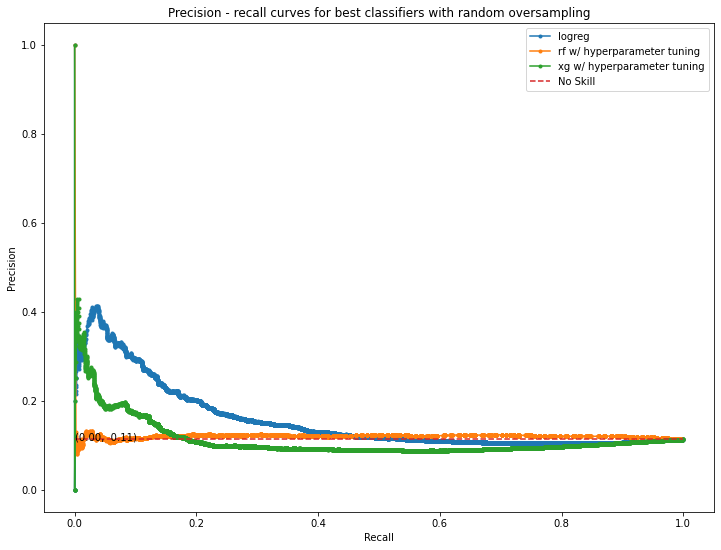

In [118]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (12, 9))

for name, prob in ro_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for best classifiers with random oversampling')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend();

We observe that we get even higher average precision scores on the cross-validated training set when we oversample. However, our test scores are still poor.

## Oversampling with SMOTE (Synthetic Minority Oversampling Technique)

SMOTE oversamples the minority class by interpolating between nearest neigbhours associated with minority examples. This is a more suffisticated way of oversampling the dataset rather than resampling with replacement. We will determine if SMOTE provides improved performance scores on our base algorithms.

### Creating SMOTE Dataset

In [119]:
oversampling = SMOTE()
X_SMOTE, y_SMOTE = oversampling.fit_resample(X_train, y_train)

Compare 

In [120]:
#Data is balanced
y_SMOTE.value_counts()

0    25572
1    25572
Name: response, dtype: int64

### Train Models on SMOTE Dataframe And Assess Performance


In [121]:
SMOTE_logreg_cv = cv_performance(logreg, feature = X_SMOTE, target = y_SMOTE)
SMOTE_rf_hyp_cv = cv_performance(rf_hyp, feature = X_SMOTE, target = y_SMOTE)
SMOTE_xg_hyp_cv = cv_performance(xg_hyp, feature = X_SMOTE, target = y_SMOTE)

In [122]:
SMOTE_logreg_cv_mean, _ = cv_mean_std(SMOTE_logreg_cv)
SMOTE_rf_hyp_cv_mean, _ = cv_mean_std(SMOTE_rf_hyp_cv)
SMOTE_xg_hyp_cv_mean, _ = cv_mean_std(SMOTE_xg_hyp_cv)

In [123]:
SMOTE_logreg_pred, SMOTE_logreg_prob, SMOTE_logreg_coef, _ = pred(logreg, Xtr = X_SMOTE, ytr = y_SMOTE)
SMOTE_rf_hyp_pred, SMOTE_rf_hyp_prob, SMOTE_rf_hyp_coef, _ = pred_tree(rf_hyp, Xtr = X_SMOTE, ytr = y_SMOTE)
SMOTE_xg_hyp_pred, SMOTE_xg_hyp_prob, SMOTE_xg_hyp_coef, _ = pred_tree(xg_hyp, Xtr = X_SMOTE, ytr = y_SMOTE)

In [124]:
SMOTE_logreg_auc_pr = average_precision_score(y_test, SMOTE_logreg_prob)
SMOTE_rf_hyp_auc_pr = average_precision_score(y_test, SMOTE_rf_hyp_prob)
SMOTE_xg_hyp_auc_pr = average_precision_score(y_test, SMOTE_xg_hyp_prob)

In [125]:
SMOTE_aucpr_cv_scores = [SMOTE_logreg_cv_mean, SMOTE_rf_hyp_cv_mean, SMOTE_xg_hyp_cv_mean]
SMOTE_aucpr_test_scores = [SMOTE_logreg_auc_pr, SMOTE_rf_hyp_auc_pr, SMOTE_xg_hyp_auc_pr]
SMOTE_performance_scores = dict(SMOTE_cv_scores =  SMOTE_aucpr_cv_scores, SMOTE_test_scores = SMOTE_aucpr_test_scores)
SMOTE_probs = [SMOTE_logreg_prob, SMOTE_rf_hyp_prob, SMOTE_xg_hyp_prob]
SMOTE_info = zip(best_models, SMOTE_probs)

In [126]:
SMOTE_perf_df = pd.DataFrame(SMOTE_performance_scores, index = best_models)
SMOTE_perf_df.sort_values(by = 'SMOTE_test_scores', ascending = False)

,SMOTE_cv_scores,SMOTE_test_scores
xg w/ hyperparameter tuning,0.975701,0.476895
logreg,0.825003,0.463602
rf w/ hyperparameter tuning,0.987076,0.407518


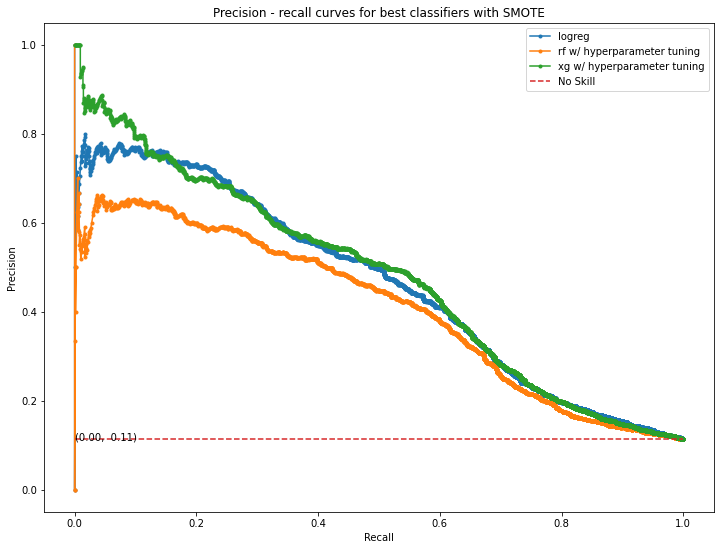

In [127]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (12, 9))

for name, prob in SMOTE_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for best classifiers with SMOTE')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend();

SMOTE definitely produced scores that were much better than random oversampling, but these results were not significantly better than scores obtained on the base models for the test set.

## SMOTE with Undersampling

In addition to synthetic oversampling of the minority class one could also undersample the majority. This may lead to better scores.We shall create a new dataset with this approach and determine the performance of our models.

### Create SMOTE with Undersampling Dataset

We will oversample the minority samples to be 50% of the majority samples and undersample the majority samples to be 50% of the majority samples.

In [128]:
#Create SMOTE oversampling of minority class and undersampling of majority class
oversampler = SMOTE(sampling_strategy = 0.5)
undersampler = RandomUnderSampler(sampling_strategy = 0.5)
steps = [('oversampler', oversampler), ('undersampler', undersampler)]
pipeline = pipeline(steps = steps)

In [129]:
#Create SMOTE dataset that has been undersampled
X_SMOTE_under, y_SMOTE_under = pipeline.fit_resample(X_train, y_train)

In [130]:
#Review class distribution
y_SMOTE_under.value_counts()

0    25572
1    12786
Name: response, dtype: int64

### Train Models on undersampled SMOTE Dataframe And Assess Performance


In [131]:
SMOTE_under_logreg_cv = cv_performance(logreg, feature = X_SMOTE_under, target = y_SMOTE_under)
SMOTE_under_rf_hyp_cv = cv_performance(rf_hyp, feature = X_SMOTE_under, target = y_SMOTE_under)
SMOTE_under_xg_hyp_cv = cv_performance(xg_hyp, feature = X_SMOTE_under, target = y_SMOTE_under)

In [132]:
SMOTE_under_logreg_cv_mean, _ = cv_mean_std(SMOTE_under_logreg_cv)
SMOTE_under_rf_hyp_cv_mean, _ = cv_mean_std(SMOTE_under_rf_hyp_cv)
SMOTE_under_xg_hyp_cv_mean, _ = cv_mean_std(SMOTE_under_xg_hyp_cv)

In [133]:
SMOTE_under_logreg_pred, SMOTE_under_logreg_prob, SMOTE_under_logreg_coef, _ = pred(logreg, Xtr = X_SMOTE_under, ytr = y_SMOTE_under)
SMOTE_under_rf_hyp_pred, SMOTE_under_rf_hyp_prob, SMOTE_under_rf_hyp_coef, _ = pred_tree(rf_hyp, Xtr = X_SMOTE_under, ytr = y_SMOTE_under)
SMOTE_under_xg_hyp_pred, SMOTE_under_xg_hyp_prob, SMOTE_under_xg_hyp_coef, _ = pred_tree(xg_hyp, Xtr = X_SMOTE_under, ytr = y_SMOTE_under)

In [134]:
SMOTE_under_logreg_auc_pr = average_precision_score(y_test, SMOTE_under_logreg_prob)
SMOTE_under_rf_hyp_auc_pr = average_precision_score(y_test, SMOTE_under_rf_hyp_prob)
SMOTE_under_xg_hyp_auc_pr = average_precision_score(y_test, SMOTE_under_xg_hyp_prob)

In [135]:
SMOTE_under_aucpr_cv_scores = [SMOTE_under_logreg_cv_mean, SMOTE_under_rf_hyp_cv_mean, SMOTE_under_xg_hyp_cv_mean]
SMOTE_under_aucpr_test_scores = [SMOTE_under_logreg_auc_pr, SMOTE_under_rf_hyp_auc_pr, SMOTE_under_xg_hyp_auc_pr]
SMOTE_under_performance_scores = dict(SMOTE_under_cv_scores =  SMOTE_under_aucpr_cv_scores, SMOTE_under_test_scores = SMOTE_under_aucpr_test_scores)
SMOTE_under_probs = [SMOTE_under_logreg_prob, SMOTE_under_rf_hyp_prob, SMOTE_under_xg_hyp_prob]
SMOTE_under_info = zip(best_models, SMOTE_under_probs)

In [136]:
SMOTE_under_perf_df = pd.DataFrame(SMOTE_under_performance_scores, index = best_models)
SMOTE_under_perf_df.sort_values(by = 'SMOTE_under_test_scores', ascending = False)

,SMOTE_under_cv_scores,SMOTE_under_test_scores
xg w/ hyperparameter tuning,0.929211,0.479435
logreg,0.719688,0.468005
rf w/ hyperparameter tuning,0.944094,0.412529


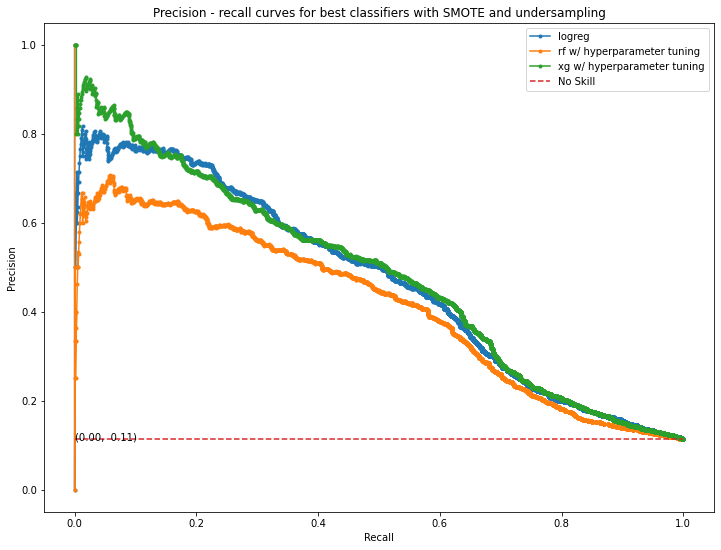

In [137]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (12, 9))

for name, prob in SMOTE_under_info:
    auc_plot(y_test, prob, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for best classifiers with SMOTE and undersampling')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend();

SMOTE with undersampling does not improve the performance of the models.

# Model selection

### XGBoost with hyperparameter tuning

In [138]:
#Check classification report
print(f'Cross validation train set AUC-PR score: {xg_search.best_score_:.2f}')
print(f'Test set AUC-PR score                  : {xg_hyp_auc_pr:.2f}')
print(f'Test set AUC-ROC score                 : {roc_auc_score(y_test, xg_hyp_prob):.2f}')
print(f'Test set F2 score                      : {fbeta_score(y_test, logreg_hyp_pred, beta = 2):.2f}')
print(classification_report(y_test, xg_hyp_pred))

Cross validation train set AUC-PR score: 0.46
Test set AUC-PR score                  : 0.48
Test set AUC-ROC score                 : 0.81
Test set F2 score                      : 0.29
              precision    recall  f1-score   support

           0       0.91      0.98      0.95     10960
           1       0.66      0.27      0.39      1391

    accuracy                           0.90     12351
   macro avg       0.79      0.63      0.67     12351
weighted avg       0.89      0.90      0.88     12351



### Logistic regression

In [139]:
#Check classification report
print(f'Cross validation train set AUC-PR score: {logreg_cv_mean:.2f}')
print(f'Test set AUC-PR score                  : {logreg_auc_pr:.2f}')
print(f'Test set AUC-ROC score                 : {roc_auc_score(y_test, logreg_prob):.2f}')
print(f'Test set F2 score                      : {fbeta_score(y_test, logreg_pred, beta = 2):.2f}')
print(classification_report(y_test, logreg_pred))

Cross validation train set AUC-PR score: 0.45
Test set AUC-PR score                  : 0.48
Test set AUC-ROC score                 : 0.81
Test set F2 score                      : 0.29
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10960
           1       0.69      0.25      0.37      1391

    accuracy                           0.90     12351
   macro avg       0.80      0.62      0.66     12351
weighted avg       0.89      0.90      0.88     12351



### Random forest with hyperparameter tuning

In [140]:
#Check classification report
print(f'Cross validation train set AUC-PR score: {rf_search.best_score_:.2f}')
print(f'Test set AUC-PR score                  : {rf_hyp_auc_pr:.2f}')
print(f'Test set AUC-ROC score                 : {roc_auc_score(y_test, rf_hyp_prob):.2f}')
print(f'Test set F2 score                      : {fbeta_score(y_test, rf_hyp_pred, beta = 2):.2f}')
print(classification_report(y_test, rf_hyp_pred))

Cross validation train set AUC-PR score: 0.41
Test set AUC-PR score                  : 0.42
Test set AUC-ROC score                 : 0.78
Test set F2 score                      : 0.34
              precision    recall  f1-score   support

           0       0.92      0.97      0.94     10960
           1       0.55      0.31      0.40      1391

    accuracy                           0.89     12351
   macro avg       0.74      0.64      0.67     12351
weighted avg       0.88      0.89      0.88     12351



# Final model training

In [141]:
final_model = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder = False, eval_metric = 'logloss', max_depth = 3, subsample = 1.0, seed = 77)

In [142]:
final_model_cv = cv_performance(final_model, feature = X_scaled, target = y)

In [143]:
final_model_cv_mean, final_model_cv_std = cv_mean_std(final_model_cv)
final_model_cv_mean, final_model_cv_std

(0.08828162576071952, 0.05831196740554073)

In [144]:
final_model.fit(X_scaled, y);

The model slightly performs better than a no skill classifier (at 0.11), maybe even worse based on the standard deviation. 

# Model application

In [145]:
application_set_y = application_set.response
application_set_x = application_set.drop(columns = ['response'])

In [146]:
application_set_y.head()

11994    0
39824    0
10278    0
29948    0
13012    0
Name: response, dtype: int64

In [147]:
application_set_x.head()

,age,currentCampaignContacts,daysLastContacted,previousCampaignContacts,employmentRate,cpi,cci,euribor3m,noEmployed,age_grp_rr,...,cci_grp_neg45.9_neg41,cci_grp_neg51_neg46,euribor3m_grp_0.6_1.5,euribor3m_grp_1.501_2.4,euribor3m_grp_2.401_3.3,euribor3m_grp_3.301_4.2,euribor3m_grp_4.201_5.1,noEmployed_grp_4960_5050,noEmployed_grp_5050.1_5140,noEmployed_grp_5140.1_5230
11994,39,4,999,0,1.4,94.465,-41.8,4.958,5228.1,0.097467,...,1,0,0,0,0,0,1,0,0,1
39824,29,1,999,0,-1.7,94.055,-39.8,0.713,4991.6,0.147315,...,0,0,1,0,0,0,0,1,0,0
10278,50,4,999,0,1.4,94.465,-41.8,4.960,5228.1,0.081738,...,1,0,0,0,0,0,1,0,0,1
29948,40,2,999,0,-1.8,93.075,-47.1,1.405,5099.1,0.097467,...,0,1,1,0,0,0,0,0,1,0
13012,34,3,999,0,1.4,93.918,-42.7,4.962,5228.1,0.097467,...,1,0,0,0,0,0,1,0,0,1


In [148]:
scaler = StandardScaler(with_mean= False)

In [149]:
transformed_data = scaler.fit_transform(application_set_x)

In [150]:
predicted_response = final_model.predict(transformed_data)
predicted_response_df = pd.DataFrame(predicted_response, columns = ['predicted_response'])
predicted_response_df.head()

,predicted_response
0,0
1,0
2,0
3,1
4,0


In [151]:
pred_prob_app = final_model.predict_proba(transformed_data)[:, 1]

In [152]:
#Adding predicted responses to application_set dataframe
application_inter = pd.merge(pd.DataFrame(application_set_x, columns = feature_names).reset_index(drop = True), predicted_response_df.reset_index(drop = True), left_index = True, right_index = True)
#Adding original responses to application_set dataframe
application_response = pd.merge(application_inter.reset_index(drop = True),(pd.DataFrame(application_set_y).reset_index(drop = True)), left_index = True, right_index = True)

In [153]:
application_response[['age', 'response', 'predicted_response']]

,age,response,predicted_response
0,39,0,0
1,29,0,0
2,50,0,0
3,40,0,1
4,34,0,0
5,29,0,0
6,28,1,0
7,30,0,0
8,54,1,0
9,43,0,1


In [154]:
print(f'Test set AUC-PR score                  : {average_precision_score(application_set_y, pred_prob_app):.2f}')
print(f'Test set AUC-ROC score                 : {roc_auc_score(application_set_y, pred_prob_app):.2f}')
print(f'Test set F2 score                      : {fbeta_score(application_set_y, predicted_response, beta = 2):.2f}')
print(classification_report(application_set_y, predicted_response))

Test set AUC-PR score                  : 0.25
Test set AUC-ROC score                 : 0.53
Test set F2 score                      : 0.00
              precision    recall  f1-score   support

           0       0.78      0.88      0.82        16
           1       0.00      0.00      0.00         4

    accuracy                           0.70        20
   macro avg       0.39      0.44      0.41        20
weighted avg       0.62      0.70      0.66        20



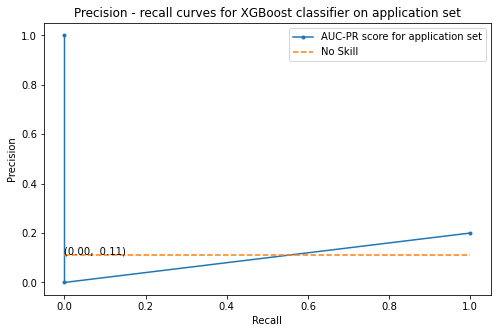

In [155]:
no_skill = len(y_test[y_test==1]) / len(y_test)
fig, axs = plt.subplots(figsize = (8, 5))
name = 'AUC-PR score for application set'

auc_plot(application_set_y, predicted_response, name)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - recall curves for XGBoost classifier on application set')
plt.plot([0, 1], [no_skill, no_skill], linestyle = '--', label = 'No Skill')
plt.annotate(f'(0.00, {no_skill: .2f})',(0, no_skill))
plt.legend()
plt.savefig('..\\reports\\figures\\logreg.png', bbox_inches="tight");

# Conclusion

The goal of our project was to create a model to predict the response of a marketing campagne, whether a 'yes' or 'no'. To do so, we created various imperfect models that improved our ability to predict the response. We highlighted the importance of prioritizing the prediction of our positive class because these were clients, especially because of the imbalanced nature of the dataset, with a 1:8 ratio of clients who responded positively to the marketing campagne and those who did not. Accordingly, we determined that precision and recall were the most useful metrics of relevance and the area under the precision-recall curve as the most important scoring metric followed by the f1 score. 

From the above models, the logisitic regression model with class weights offered the best performance on the test set, both in terms of the average precision and the f1 score for the minority class. This is the model we recommend to the business.

Generally, the logisitic regression algorithm performed better than the random forest and XGBoost algorithm. We also noted that random undersampling and oversampling techniques yielded poor results.

# Further Improvements

The business should consider the following measures to improve the performance of the model.

1. Gather more data as they continue their campagne
2. Review other algorithms to determine if they improve performance
3. Engineer additional features